# Project Overview

In this capstone project I am going attempt to predict when a Broadway show should close.  The idea behind this development is that an interface would be developed for producers that would allow them to enter their numbers from the previous week and determine if they are in a "red zone", therefore closing.  

I have divided the project up into three parts:

**Baseline Modeling**
In this section is an indepth Exploratory Data Analysis of Broadway weekly grosses, types of shows, and other important features that may influence whether a show will close or not.  SVM and Random Forest are used as baseline modeling techniques while addressing things like class imabalance.  

**ANN for Broadway Grosses**
Using the Keras API an Artificial Neural Network is constructed to use sophisticated algorithms to determine if a Broadway show should close or not.

**Wicked Time Series Analysis**
The core to this data is the passage of time and how much money the show is making.  It is essential to take an in depth look at time series, how it can influence our predictions, and its components like seasonality.  It is concluded with a prediction of how much money the Broadway show Wicked lost the first year of COVID-19.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

# The Data

This data was orginally parsed from the Broadway League website and can be found [here](https://www.broadwayleague.com/research/grosses-broadway-nyc/#weekly_grosses).

The Broadway League is an internationally recognized organization that maintains the standards and efficacy of Broadway shows.  They are not connected with the production companies and they do not record the grosses.  The grosses are recorded by the box office that remains a neutral 3rd party.  
The original data came with 12 rows:

|Feature|Description|
|:----:|:----:|
|date|Past 5 years of all Broadway data.|
|show|Name of the show.|
|type|Distinguished by Play, Musical, or Special.|
|theatre|Which physical theatre the show takes place at.|
|previews|How many of the performances were previews.|
|performances|How many performances occured not including previews.|
|grosses|Total revenue generated before running costs.|
|prev week grosses|The revenue generated from the previous week.|
|GG%GP|This is the percentage of the revenue generated out of the possible grossings.  Number is defined by every seat in the house being sold at full price.|
|attendance|How many people attended the Performance.|
|prev week attendance|How many people attended last week.|
|%capacity|How much of the theatre was full.|

## Feture Engineering

In addition I added four rows as additional features:

|Feature|Description|
|:---:|:---:|
|Close Month| This demarcates the month of closing.|
|Genre|Includes: Mystery, Comedy, Drama, Alternative, Jukebox, Tragedy|
|Tony Noms|The number of Tony nominations the show recieved.|
|Tony Awards|The number of Tony awards the show won.|

The Features were all originally collected and stored in a large Excel file.  
Creating a closing month feature was the vital column that my argument leans on.  The idea is that we get the computer to pick up on the fact that the show is not doing well and therefore is closing.  By marking the last month of a shows life we can try to run sophisticated algorithms that attempt to detect when that will be based on other features.

In [2]:
#Load data
df = pd.read_excel('Broadway_Grosses.xlsx')

In [3]:
##Initial look at the data and it read in nicely.
df.head()

date  show  type theatre  previews  performances  grosses  \
0 2017-05-21  1984  Play  Hudson         4             0   212626   
1 2017-05-28  1984  Play  Hudson         7             0   298438   
2 2017-06-04  1984  Play  Hudson         8             0   282053   
3 2017-06-11  1984  Play  Hudson         8             0   288446   
4 2017-06-18  1984  Play  Hudson         8             0   301461   

  prev_week_gross  GG%GP  attend  prev_week_attend  %cap  close_month  \
0               $   0.48    3378               NaN  0.87            0   
1          212626   0.45    5079            3378.0  0.75            0   
2          298438   0.36    5230            5079.0  0.67            0   
3          282053   0.37    5554            5230.0  0.72            0   
4          288446   0.39    6018            5554.0  0.78            0   

     genre  tony_noms  tony_awards  
0  Mystery          1            0  
1  Mystery          1            0  
2  Mystery          1            0  
3  Mystery          1            0  
4  Mystery          1            0

In [5]:
#Looking to makes sure that shows are only categorized as musical, play, or special.
df['type'].nunique()

3

In [6]:
df['type'].unique()

array(['Play', 'Musical', 'Special'], dtype=object)

In [7]:
#Noting that we have over 8,000 rows but only working with 233 shows.
print('----------------------------------------------------------')
print('The number of Broadway Shows in this dataset is:',df['show'].nunique())

----------------------------------------------------------
The number of Broadway Shows in this dataset is: 233


In [8]:
df['show'].unique()

array([1984, 'A CHRISTMAS CAROL 2019', "A SOLDIER'S PLAY",
       "AIN'T TOO PROUD", 'A BRONX TALE THE MUSICAL',
       'A DELICATE BALANCE 2014', "A DOLL'S HOUSE, PART 2",
       "A GENTLEMAN'S GUIDE TO LOVE AND MURDER",
       'A VIEW FROM THE BRIDGE 2015', 'AIRLINE HIGHWAY', 'ALADDIN',
       'ALL MY SONS 2019', 'AMERICAN SON', 'AMERICAN UTOPIA',
       'ALLEGIANCE', 'ALTON BROWN LIVE: EAT YOUR SCIENCE',
       'AMAZING GRACE', 'AMÉLIE', 'AMERICAN PSYCHO', 'AN ACT OF GOD',
       'AN ACT OF GOD 2016', 'AN AMERICAN IN PARIS', 'ANASTASIA',
       'ANGELS IN AMERICA 2018', 'BANDSTAND', 'BARRY MANILOW',
       'BE MORE CHILL', 'BEAUTIFUL', 'BEETLEJUICE', 'BETRAYAL 2019',
       'BURN THIS 2019', 'BERNHARDT/HAMLET', 'BLACK TO THE FUTURE',
       'BLACKBIRD', 'BRIGHT STAR', "CABARET '14", 'CAROUSEL 2018',
       'CATS 2016', 'CELEBRITY AUTOBIOGRAPHY',
       'CHARLIE AND THE CHOCOLATE FACTORY', 'CHICAGO', 'CHOIR BOY',
       'CHILDREN OF A LESSER GOD 2018', 'CHINA DOLL', 'COME FROM AWAY',

In [9]:
# This is an extremely clean and tight data set since it was custom created.  
# The 213 missing data points account for the first week of a show since there would be no previous records for a new show.
df.isna().sum()

date                  0
show                  0
type                  0
theatre               0
previews              0
performances          0
grosses               0
prev_week_gross       0
GG%GP                 0
attend                0
prev_week_attend    213
%cap                  0
close_month           0
genre                 0
tony_noms             0
tony_awards           0
dtype: int64

In [10]:
# Changing the show names from all caps to standard format.
df['show'] = df['show'].str.capitalize()

In [11]:
#getting rid of the few null values.
df = df.dropna()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7978 entries, 21 to 8209
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              7978 non-null   datetime64[ns]
 1   show              7978 non-null   object        
 2   type              7978 non-null   object        
 3   theatre           7978 non-null   object        
 4   previews          7978 non-null   int64         
 5   performances      7978 non-null   int64         
 6   grosses           7978 non-null   int64         
 7   prev_week_gross   7978 non-null   object        
 8   GG%GP             7978 non-null   float64       
 9   attend            7978 non-null   int64         
 10  prev_week_attend  7978 non-null   float64       
 11  %cap              7978 non-null   float64       
 12  close_month       7978 non-null   int64         
 13  genre             7978 non-null   object        
 14  tony_noms         7978 

In [13]:
#For whatever reason prev_week_gross is an object and we need it as an integer or float for analytic purposes.
df['prev_week_gross'] = df['prev_week_gross'].values.astype('float32')

<ipython-input-13-848dedf7b931>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev_week_gross'] = df['prev_week_gross'].values.astype('float32')


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7978 entries, 21 to 8209
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              7978 non-null   datetime64[ns]
 1   show              7978 non-null   object        
 2   type              7978 non-null   object        
 3   theatre           7978 non-null   object        
 4   previews          7978 non-null   int64         
 5   performances      7978 non-null   int64         
 6   grosses           7978 non-null   int64         
 7   prev_week_gross   7978 non-null   float32       
 8   GG%GP             7978 non-null   float64       
 9   attend            7978 non-null   int64         
 10  prev_week_attend  7978 non-null   float64       
 11  %cap              7978 non-null   float64       
 12  close_month       7978 non-null   int64         
 13  genre             7978 non-null   object        
 14  tony_noms         7978 

In [15]:
#Taking a general look at numbers.  This is pretty normally distributed data with some outliers.
df.describe()

previews  performances       grosses  prev_week_gross        GG%GP  \
count  7978.000000   7978.000000  7.978000e+03         7978.000  7978.000000   
mean      0.500376      7.429556  9.756514e+05       966886.125     0.736296   
std       1.830696      1.968312  5.829954e+05       586386.000     0.248156   
min       0.000000      0.000000  4.849600e+04        32574.000     0.030000   
25%       0.000000      8.000000  5.825955e+05       571956.500     0.540000   
50%       0.000000      8.000000  8.381615e+05       831056.500     0.710000   
75%       0.000000      8.000000  1.209606e+06      1203708.000     0.930000   
max       8.000000     17.000000  4.041493e+06      4041493.000     1.700000   

             attend  prev_week_attend         %cap  close_month    tony_noms  \
count   7978.000000       7978.000000  7978.000000  7978.000000  7978.000000   
mean    8512.940963       8432.167837     0.870223     0.129732     6.666834   
std     2827.493530       2889.371202     0.136111     0.336029     4.849554   
min     1384.000000        500.000000     0.230000     0.000000     0.000000   
25%     6474.250000       6387.500000     0.780000     0.000000     2.000000   
50%     8107.000000       8060.500000     0.900000     0.000000     7.000000   
75%    10483.750000      10447.750000     0.990000     0.000000    10.000000   
max    24305.000000      17517.000000     1.040000     1.000000    16.000000   

       tony_awards  
count  7978.000000  
mean      2.755076  
std       3.325390  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       5.000000  
max      11.000000

In [16]:
df.isna().sum()

date                0
show                0
type                0
theatre             0
previews            0
performances        0
grosses             0
prev_week_gross     0
GG%GP               0
attend              0
prev_week_attend    0
%cap                0
close_month         0
genre               0
tony_noms           0
tony_awards         0
dtype: int64

In [17]:
#setting the date as the index for ease of use, note that object type was imported as a datetime64.
df = df.set_index('date')

In [18]:
df.head()

show  type theatre  previews  performances  \
date                                                                       
2019-11-17  A christmas carol 2019  Play  Lyceum         8             0   
2019-11-24  A christmas carol 2019  Play  Lyceum         1             7   
2019-12-01  A christmas carol 2019  Play  Lyceum         0             9   
2019-12-08  A christmas carol 2019  Play  Lyceum         0             8   
2019-12-15  A christmas carol 2019  Play  Lyceum         0             8   

            grosses  prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                          
2019-11-17   257525         106450.0   0.30    4194            1651.0  0.62   
2019-11-24   384493         257525.0   0.45    5590            4194.0  0.82   
2019-12-01   734745         384493.0   0.77    5988            5590.0  0.78   
2019-12-08   757702         734745.0   0.90    6164            5988.0  0.91   
2019-12-15   822983         757702.0   0.97    6619            6164.0  0.98   

            close_month     genre  tony_noms  tony_awards  
date                                                       
2019-11-17            0  Seasonal          5            3  
2019-11-24            0  Seasonal          5            3  
2019-12-01            0  Seasonal          5            3  
2019-12-08            0  Seasonal          5            3  
2019-12-15            0  Seasonal          5            3

# EDA

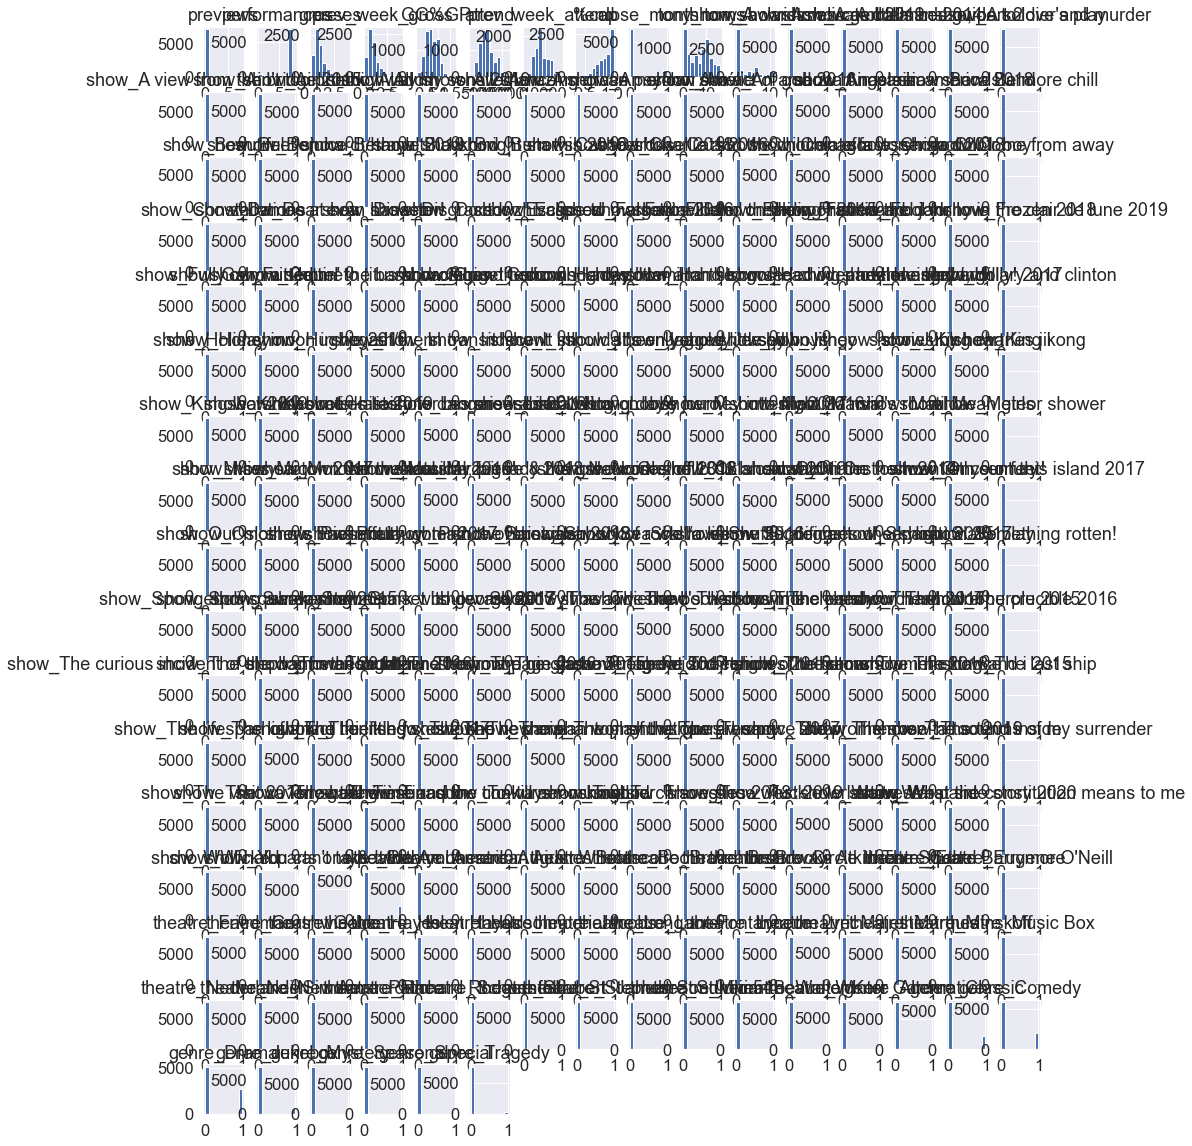

In [79]:
#A histogram of all quantitative features is usually my first step.  
#  Although this is quick and rough it shows us that we have very pretty evenly distributed data
df.hist(figsize=(15,20))
plt.show()

We are going to take a deeper look into 3 specific shows: Hamilton, Anastasia, and Beetlejuice.
Items to note about each show as follows:

**Hamilton**- Definitely what we consider an anomolie.  The success of a show like Hamilton is extremely rare and we see by the visualizations of their data that it has abnormal habits.  Not a great show data wise to reference.

**Anastasia**-  This show is your average broadway show.  It ran for over a year and opened to great numbers that were sometimes over 1 million a week threshold. However we can see its decline very clearly from the graphs.

**Beetlejuice**-  The newcomer underdog.  The show did not open to raving success but quickly became a cult phenomenon. We can see its giant uptick in sales visually.

### Hamilton Data

In [20]:
#creating three data frames each for the respective show.
df_hamilton = df[df.show.str.contains('Hamilton')]

In [21]:
df_hamilton.head()

show     type          theatre  previews  performances  \
date                                                                     
2015-07-26  Hamilton  Musical  Richard Rodgers         7             0   
2015-08-02  Hamilton  Musical  Richard Rodgers         8             0   
2015-08-09  Hamilton  Musical  Richard Rodgers         4             4   
2015-08-16  Hamilton  Musical  Richard Rodgers         0             8   
2015-08-23  Hamilton  Musical  Richard Rodgers         0             8   

            grosses  prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                          
2015-07-26  1302511        1288436.0   1.12    9290            9273.0  1.00   
2015-08-02  1490816        1302511.0   1.12   10619            9290.0  1.00   
2015-08-09  1255163        1490816.0   0.94   10638           10619.0  1.01   
2015-08-16  1459314        1255163.0   1.09   10706           10638.0  1.01   
2015-08-23  1456753        1459314.0   1.09   10708           10706.0  1.01   

            close_month  genre  tony_noms  tony_awards  
date                                                    
2015-07-26            0  Drama         16           11  
2015-08-02            0  Drama         16           11  
2015-08-09            0  Drama         16           11  
2015-08-16            0  Drama         16           11  
2015-08-23            0  Drama         16           11

### Beetlejuice Data

In [22]:
df_beetlejuice = df[df.show.str.contains('Beetlejuice')]

In [23]:
df_beetlejuice.head()

show     type        theatre  previews  performances  \
date                                                                      
2019-04-07  Beetlejuice  Musical  Winter Garden         7             0   
2019-04-14  Beetlejuice  Musical  Winter Garden         7             0   
2019-04-21  Beetlejuice  Musical  Winter Garden         7             0   
2019-04-28  Beetlejuice  Musical  Winter Garden         4             4   
2019-05-05  Beetlejuice  Musical  Winter Garden         0             8   

            grosses  prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                          
2019-04-07   765711         332008.0   0.65    9903            2700.0  0.95   
2019-04-14   686456         765711.0   0.59    9506            9903.0  0.91   
2019-04-21   797929         686456.0   0.68   10375            9506.0  0.99   
2019-04-28   834395         797929.0   0.63   11977           10375.0  1.00   
2019-05-05   818904         834395.0   0.60   10086           11977.0  0.84   

            close_month   genre  tony_noms  tony_awards  
date                                                     
2019-04-07            0  Comedy          8            0  
2019-04-14            0  Comedy          8            0  
2019-04-21            0  Comedy          8            0  
2019-04-28            0  Comedy          8            0  
2019-05-05            0  Comedy          8            0

### Anastasia Data

In [24]:
df_anastasia = df[df.show.str.contains('Anastasia')]

In [25]:
df_anastasia

show     type     theatre  previews  performances  grosses  \
date                                                                          
2017-04-02  Anastasia  Musical  Broadhurst         7             0   971783   
2017-04-09  Anastasia  Musical  Broadhurst         7             0   922021   
2017-04-16  Anastasia  Musical  Broadhurst         8             0  1207938   
2017-04-23  Anastasia  Musical  Broadhurst         8             0   989231   
2017-04-30  Anastasia  Musical  Broadhurst         0             8   882853   
...               ...      ...         ...       ...           ...      ...   
2019-03-03  Anastasia  Musical  Broadhurst         0             8   557480   
2019-03-10  Anastasia  Musical  Broadhurst         0             8   681938   
2019-03-17  Anastasia  Musical  Broadhurst         0             8   837803   
2019-03-24  Anastasia  Musical  Broadhurst         0             8   920068   
2019-03-31  Anastasia  Musical  Broadhurst         0             8  1012316   

            prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                 
2017-04-02         629307.0   0.97    8012            4572.0  1.00   
2017-04-09         971783.0   0.92    7847            8012.0  0.98   
2017-04-16         922021.0   1.05    9196            7847.0  1.01   
2017-04-23        1207938.0   0.86    9061            9196.0  0.99   
2017-04-30         989231.0   0.77    9030            9061.0  0.99   
...                     ...    ...     ...               ...   ...   
2019-03-03         638470.0   0.51    7020            7576.0  0.77   
2019-03-10         557480.0   0.62    7499            7020.0  0.82   
2019-03-17         681938.0   0.77    9055            7499.0  0.99   
2019-03-24         837803.0   0.84    8948            9055.0  0.98   
2019-03-31         920068.0   0.93    8744            8948.0  0.96   

            close_month    genre  tony_noms  tony_awards  
date                                                      
2017-04-02            0  Classic          2            0  
2017-04-09            0  Classic          2            0  
2017-04-16            0  Classic          2            0  
2017-04-23            0  Classic          2            0  
2017-04-30            0  Classic          2            0  
...                 ...      ...        ...          ...  
2019-03-03            1  Classic          2            0  
2019-03-10            1  Classic          2            0  
2019-03-17            1  Classic          2            0  
2019-03-24            1  Classic          2            0  
2019-03-31            0  Classic          2            0  

[104 rows x 15 columns]

## Time Plots

In [26]:
#importing plotly
import plotly.express as px

### % Capacity Filled

**HAMILTON**

This sort of time plot for a Broadway show is definitely unprecedented.  The graph looks extremely random, but the show is in such high demand that if you look at the %Capacity on the y axis, the capacity only wavers by a 100th of a percent, therefore giving this graph an unusual look.  All capacity is above 100%.

In [27]:
px.line(df_hamilton, x=df_hamilton.index, y='%cap')

**BEETLEJUICE**

Although there is a lot of seasonality in this graph, you can see an overall upward trend.

In [28]:
px.line(df_beetlejuice, x=df_beetlejuice.index, y='%cap')

**ANASTASIA**

Same idea, although there are major seasonality and marketing spikes, there is a clear negative relationship with the amount of people coming to this show over time.

In [29]:
px.line(df_anastasia, x=df_anastasia.index, y='%cap')

### Weekly Grosses

**HAMILTON**

I have to assume that merchandise is a large part of these large numbers.  Although they are able to sell the tickets at a steep price for this show a 4 million dollar week on Broadway is unheard of.

In [30]:
px.line(df_hamilton, x=df_hamilton.index, y='grosses')

**BEETLEJUICE**

Very strong positive linear trend for these grosses.  We can see visually it would be a good idea to keep this show open.

In [31]:
px.line(df_beetlejuice, x=df_beetlejuice.index, y='grosses')

**ANASTASIA**

Again a downward trend, negative linear relationship.

In [32]:
px.line(df_anastasia, x=df_anastasia.index, y='grosses')

## General EDA

These are the average grossings by type. I believe that the average grossings for Special performances is so high due to the fact that they have predetermined closing dates making them higher in demand.  We are eventually going to drop all special performances for this reason.

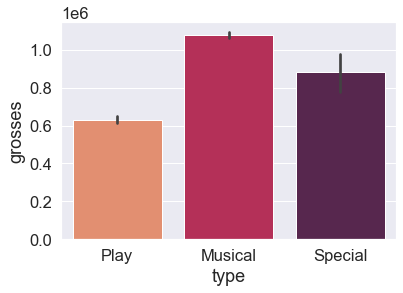

In [33]:
sns.barplot(data=df, x='type', y='grosses', palette = 'rocket_r')
plt.show()

In [34]:
from matplotlib import pyplot

In [35]:
#creating a data frame from all musicals
df_musical = df[df.type.str.contains('Musical')]

In [36]:
df_musical.head()

show     type   theatre  previews  performances  \
date                                                                     
2019-03-31  Ain't too proud  Musical  Imperial         0             8   
2019-03-10  Ain't too proud  Musical  Imperial         7             0   
2019-03-17  Ain't too proud  Musical  Imperial         7             0   
2019-03-24  Ain't too proud  Musical  Imperial         4             4   
2019-04-07  Ain't too proud  Musical  Imperial         0             8   

            grosses  prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                          
2019-03-31  1330046        1102218.0   0.92   11176           11378.0  0.98   
2019-03-10   872597         472627.0   0.70    9233            4164.0  0.93   
2019-03-17   949781         872597.0   0.76    9810            9233.0  0.98   
2019-03-24  1102218         949781.0   0.76   11378            9810.0  1.00   
2019-04-07  1337083        1330046.0   0.93   10943           11176.0  0.96   

            close_month    genre  tony_noms  tony_awards  
date                                                      
2019-03-31            0  Jukebox         12            1  
2019-03-10            0  Jukebox         12            1  
2019-03-17            0  Jukebox         12            1  
2019-03-24            0  Jukebox         12            1  
2019-04-07            0  Jukebox         12            1

In [37]:
#The number of musicals in this data set
df_musical.show.nunique()

94

<function matplotlib.pyplot.show(close=None, block=None)>

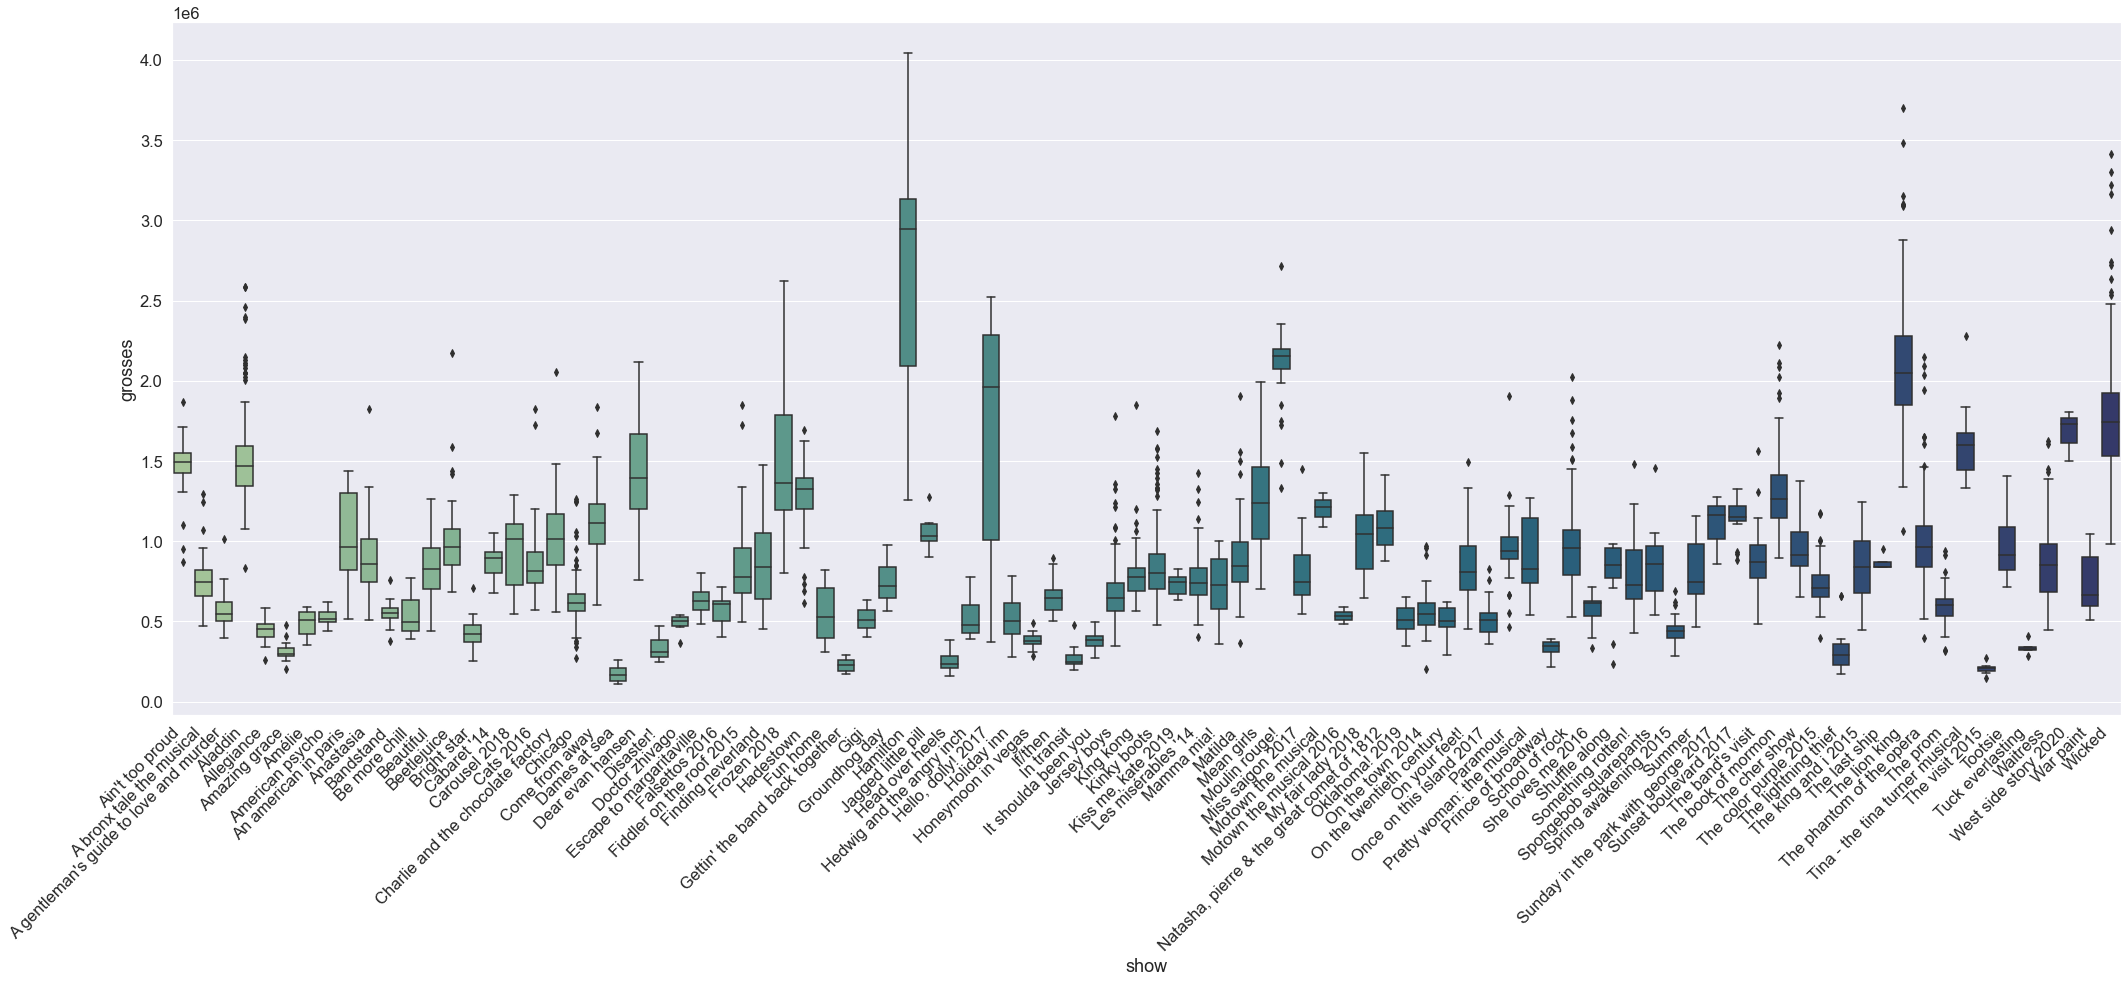

In [38]:
fig, ax = pyplot.subplots(figsize=(30,14))

#set to g and make adjustments.
g = sns.boxplot(data=df_musical, x='show', y='grosses', palette='crest')
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show

In [39]:
#creating a data frame for all plays.
df_play = df[df.type.str.contains('Play')]

In [40]:
df_play.head()

show  type theatre  previews  performances  \
date                                                                       
2019-11-17  A christmas carol 2019  Play  Lyceum         8             0   
2019-11-24  A christmas carol 2019  Play  Lyceum         1             7   
2019-12-01  A christmas carol 2019  Play  Lyceum         0             9   
2019-12-08  A christmas carol 2019  Play  Lyceum         0             8   
2019-12-15  A christmas carol 2019  Play  Lyceum         0             8   

            grosses  prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                          
2019-11-17   257525         106450.0   0.30    4194            1651.0  0.62   
2019-11-24   384493         257525.0   0.45    5590            4194.0  0.82   
2019-12-01   734745         384493.0   0.77    5988            5590.0  0.78   
2019-12-08   757702         734745.0   0.90    6164            5988.0  0.91   
2019-12-15   822983         757702.0   0.97    6619            6164.0  0.98   

            close_month     genre  tony_noms  tony_awards  
date                                                       
2019-11-17            0  Seasonal          5            3  
2019-11-24            0  Seasonal          5            3  
2019-12-01            0  Seasonal          5            3  
2019-12-08            0  Seasonal          5            3  
2019-12-15            0  Seasonal          5            3

<function matplotlib.pyplot.show(close=None, block=None)>

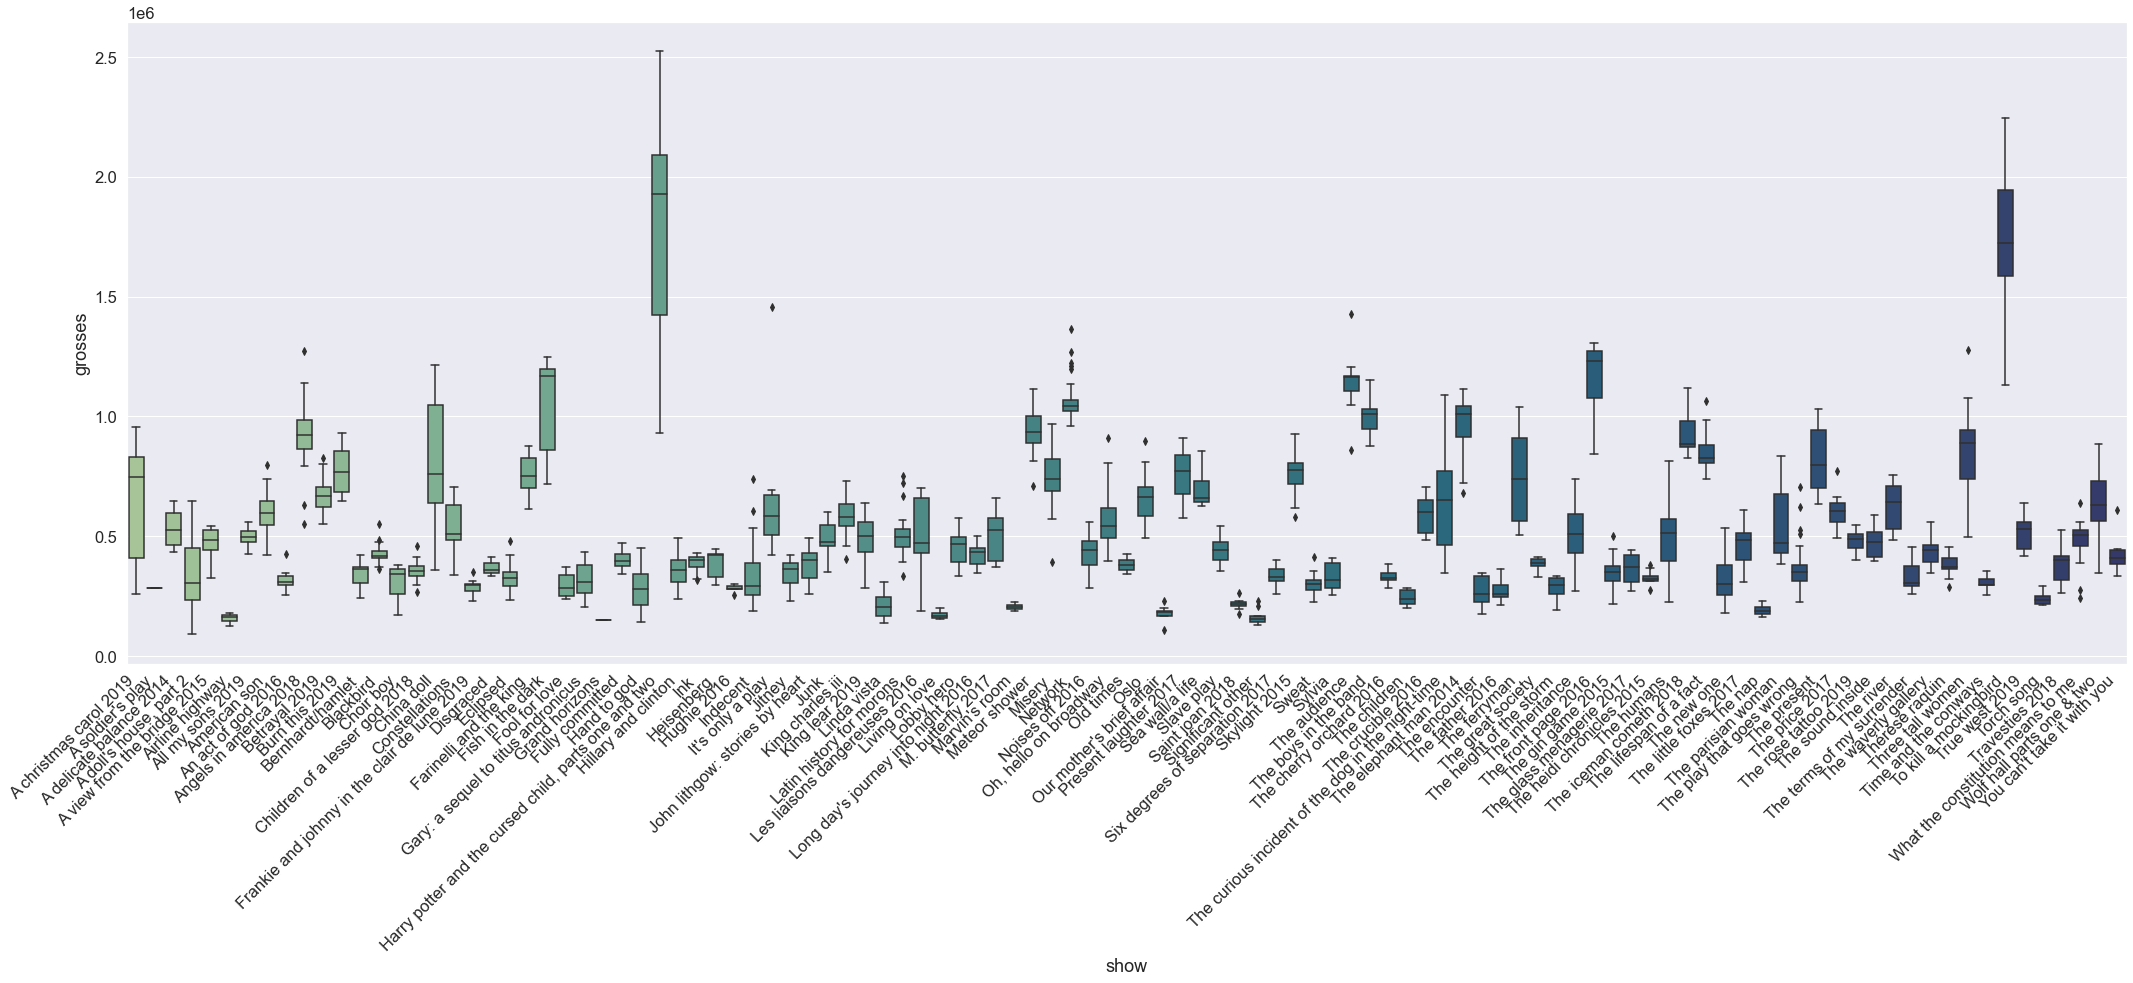

In [41]:
fig, ax = pyplot.subplots(figsize=(30,14))

g = sns.boxplot(data=df_play, x='show', y='grosses', palette='crest')
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show

<AxesSubplot:xlabel='%cap', ylabel='grosses'>

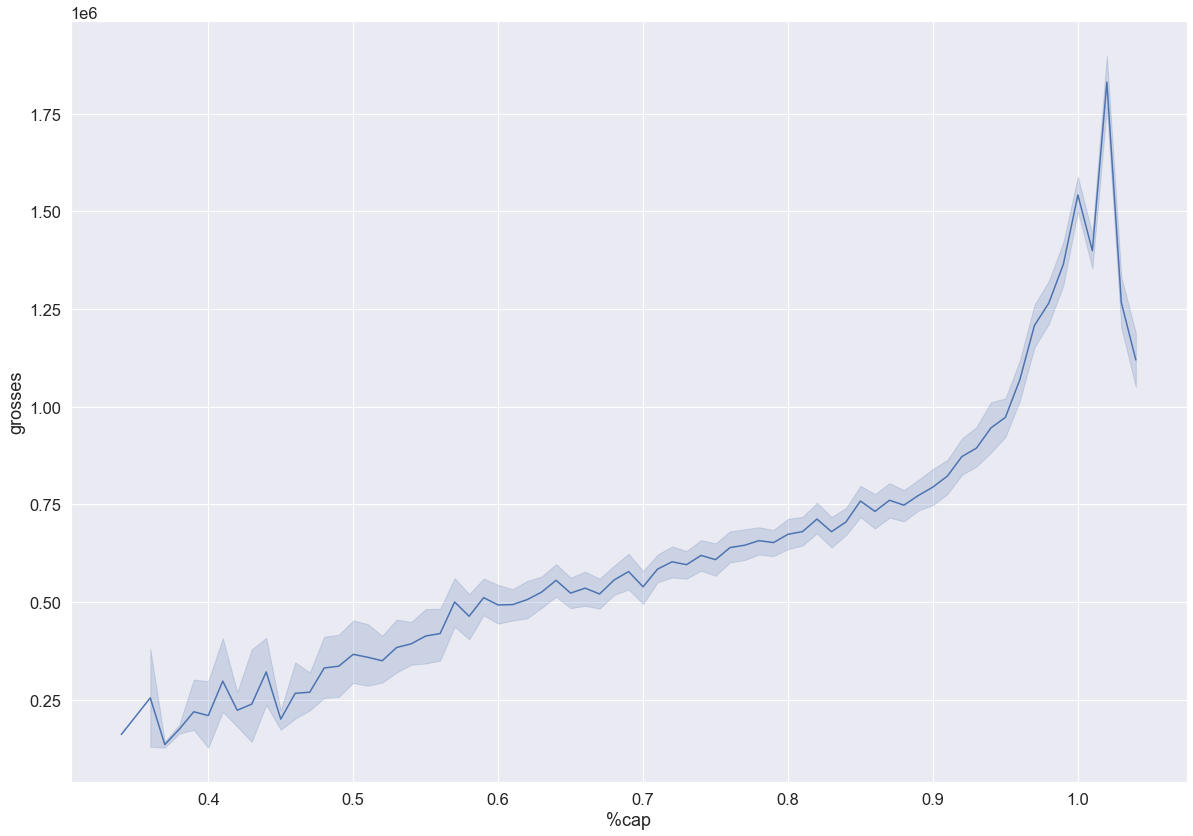

In [80]:
#Looking at the amount the house was filled v how much it made.  
#No surprise strong linear trend.
fig, ax = pyplot.subplots(figsize=(20,14))
sns.lineplot(data=df, x='%cap', y='grosses')

# Anomolie Detection through EDA

# Baseline Modeling 

In [43]:
#We need to get rid of all special performances as they will influence our data negatively.
df = df[~df.type.str.contains("Special")]

In [44]:
#Checking to make sure that we did not loose too many data points.
df.shape

(7840, 15)

## One Hote Encoding

In [45]:
#get dummies
df = pd.get_dummies(df, columns = ['show', 'type', 'theatre', 'genre'], drop_first = True)

In [46]:
#These numbers will be important later for us to know how many columns that created.
df.shape

(7840, 262)

**CREATE VARIABLES**

In [47]:
#set X equal to our closing data and the rest become features.
X = df.drop('close_month', axis = 1)
y = df['close_month']

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Models

## SVM

In [49]:
#import model
from sklearn.svm import SVC
svcls = SVC(kernel='rbf', C=1, gamma = 2**-5)
svc = svcls.fit(X_train, y_train)

In [50]:
y_pred_svc = svcls.predict(X_test)

In [51]:
from sklearn.metrics import classification_report

In [52]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1691
           1       0.00      0.00      0.00       269

    accuracy                           0.86      1960
   macro avg       0.43      0.50      0.46      1960
weighted avg       0.74      0.86      0.80      1960



/Users/andrewozbun/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [53]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred_svc)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[1691    0]
 [ 269    0]]


In [54]:
from sklearn.metrics import plot_confusion_matrix

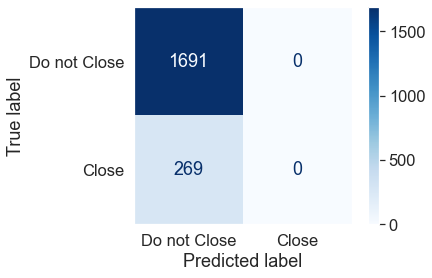

In [55]:
plot_confusion_matrix(svc, X_test, y_test, cmap=plt.cm.Blues, display_labels = ['Do not Close', 'Close'])
plt.grid(False)
plt.show()

So the confusion matrix above is terrible.  I am unsure why the machine wants everything to be do not close but it is not ideal.  My original thought was because of the Class Imbalance in the closing month column.
Class imbalance is handled below.

### Class Imbalance

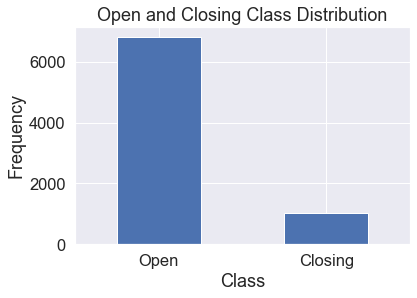

In [56]:
count_classes = pd.value_counts(df['close_month'], sort = True)
count_classes.plot(kind = 'bar', rot=0)

plt.title("Open and Closing Class Distribution")
plt.xticks((0,1), ('Open', 'Closing'))
plt.xlabel("Class")
plt.ylabel("Frequency")

plt.show()

### SMOTE

In [57]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)


##finding shortcuts for printing clean data results
print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (Percentage):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (7840, 261)
Shape of X after SMOTE: (13622, 261)

Balance of positive and negative classes (Percentage):


1    50.0
0    50.0
Name: close_month, dtype: float64

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.25, random_state=42)


### SVM Rerun

In [59]:
svc = svcls.fit(X_train, y_train)
y_pred_svc = svcls.predict(X_test)

In [60]:
cnf_matrix = confusion_matrix(y_test, y_pred_svc)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[   0 1745]
 [   0 1661]]


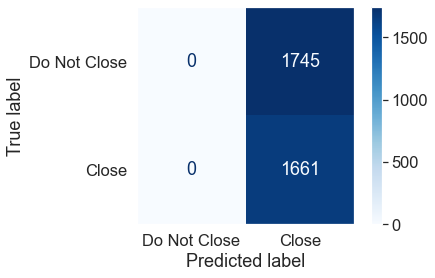

In [61]:
plot_confusion_matrix(svc, X_test, y_test, cmap=plt.cm.Blues, display_labels = ['Do Not Close', 'Close'])
plt.grid(False)
plt.show()

In [62]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1745
           1       0.49      1.00      0.66      1661

    accuracy                           0.49      3406
   macro avg       0.24      0.50      0.33      3406
weighted avg       0.24      0.49      0.32      3406



/Users/andrewozbun/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Random Forest

In [63]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=32,  
                             max_leaf_nodes=40)
rf_clf = clf.fit(X_train,y_train)

y_pred_rf = clf.predict(X_test)

In [64]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1745
           1       0.90      0.89      0.89      1661

    accuracy                           0.89      3406
   macro avg       0.89      0.89      0.89      3406
weighted avg       0.89      0.89      0.89      3406



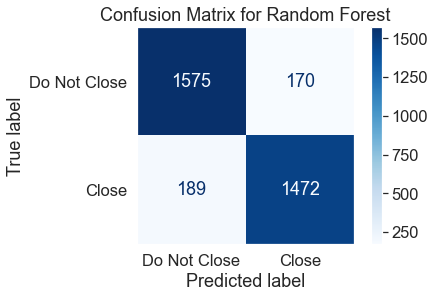

In [65]:
plot_confusion_matrix(rf_clf, X_test, y_test,  cmap=plt.cm.Blues, display_labels = ['Do Not Close', 'Close'] )
plt.title('Confusion Matrix for Random Forest')
plt.grid(False)
plt.show()

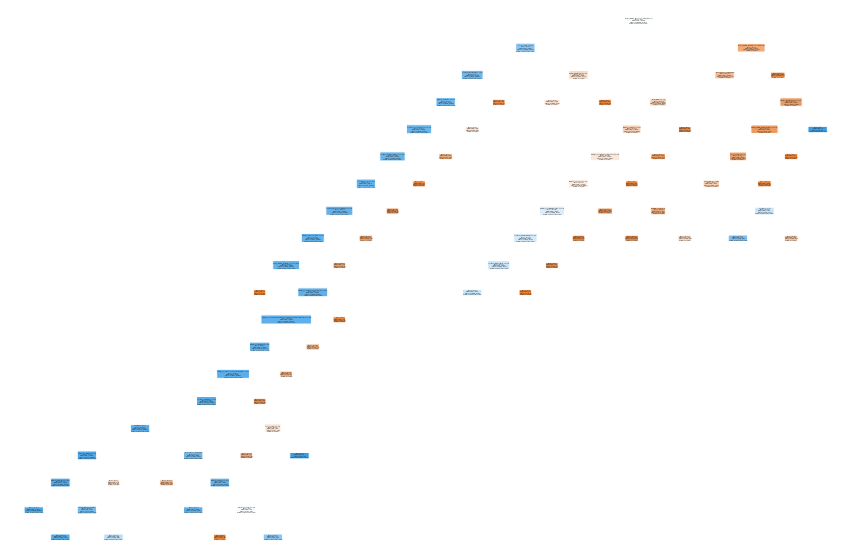

In [66]:
## Initial overfitting in this plot
from sklearn import tree
plt.figure(figsize = (15,10))
tree.plot_tree(rf_clf.estimators_[2], rounded = True, 
               filled = True, 
               class_names = ['Close', 'Do Note Close'], 
               feature_names = X.columns)
plt.show()

### Overfitting

## Feature Importance

While it is great that we can predict when a broadway show is going to close with such high accuracy, we also have to wonder what the main things were that influenced the computers decision.

In [67]:
important_features_dict = {}
for idx, val in enumerate(clf.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print('9 most important features:', important_features_list[:9])

9 most important features: [6, 3, 8, 2, 9, 5, 1, 0, 254]


In [68]:
data = important_features_dict
col = X.columns.tolist()

df_fi = pd.DataFrame.from_dict(data, orient='index',
                               columns=['feat_im'])
df_fi['feature'] = col

df_fi.head()

feat_im          feature
0  0.036239         previews
1  0.038816     performances
2  0.081915          grosses
3  0.115045  prev_week_gross
4  0.023856            GG%GP

In [69]:
df_sorted = df_fi.sort_values('feat_im', ascending=False)
df_final = df_sorted.iloc[:9]

In [70]:
df_final.head(9)

feat_im           feature
6    0.115605  prev_week_attend
3    0.115045   prev_week_gross
8    0.095650         tony_noms
2    0.081915           grosses
9    0.070701       tony_awards
5    0.048451            attend
1    0.038816      performances
0    0.036239          previews
254  0.032424      genre_Comedy

 🛎 **IMPORTANT** 
Please note that that these labels must be changed according to what the result of the previous cell states.  Features are subject to change.

In [78]:
labels = ['Previous Weeks Attendance', '# Tony Nominations', 'Previous Weeks Gross', 'Current Gross', 'GG%GP',
          '# Tony Awards', 'Jukebox Musical Genre', 'Current Attendance', 'Comedy Genre']

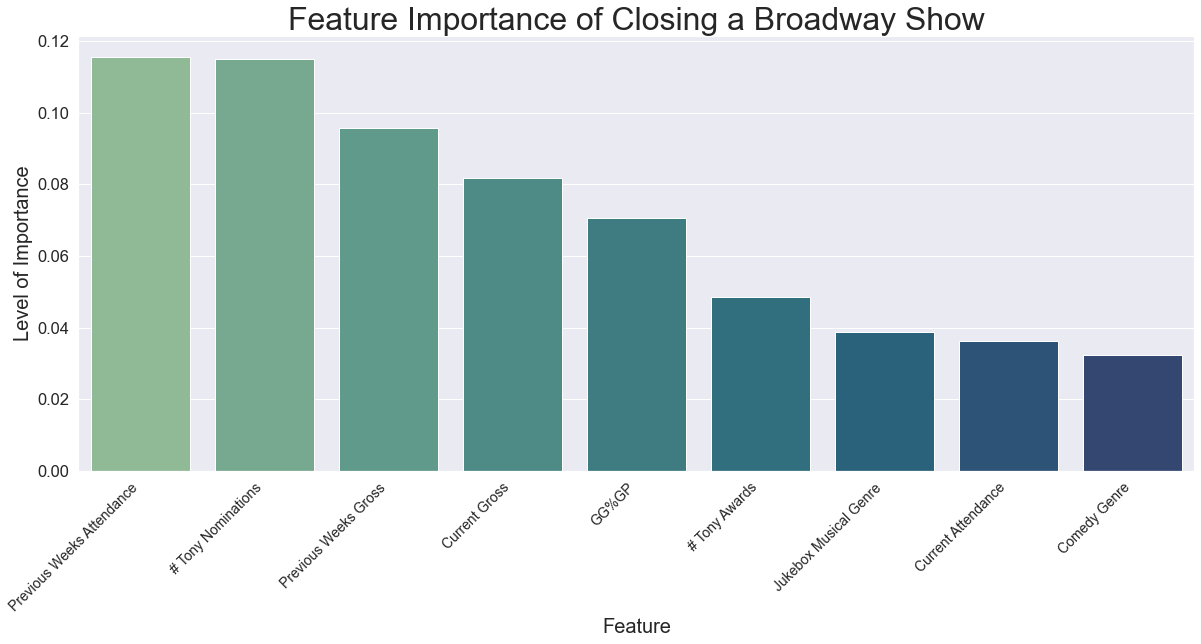

In [72]:
fig, ax = pyplot.subplots(figsize=(20,8))

g = sns.barplot(data=df_final, x='feature', y='feat_im', palette= 'crest')
g.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)

plt.xlabel("Feature", fontsize=20)
plt.ylabel("Level of Importance", fontsize=20)
plt.title("Feature Importance of Closing a Broadway Show", fontsize=32)
plt.tight_layout
plt.show()

Looking at the original graph above, it makes sense.  Its actually ideal that the data from the previous week is two of the first three most important features.  This means that the computer picked up on the fact that numbers were declining to a certain level and so it should classify it as time to close.

# Conclusion